In [1]:
import os
import pickle
import random
#from ipypb import track
import numpy as np
import sklearn.datasets 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F

torch.set_default_tensor_type(torch.FloatTensor)
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
#import palettable
mpl.style.use('default')
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Create a basic 2 moons dataset

#### Useful class

In [2]:
class BasicDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X, y, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = X
        self.y = y
        self.landmarks_frame = X.size(0)
        self.transform = transform

    def __len__(self):
        return self.landmarks_frame

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.X[idx], self.y[idx]

#### Helper for figure

In [3]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

## Plot and normalise dataset

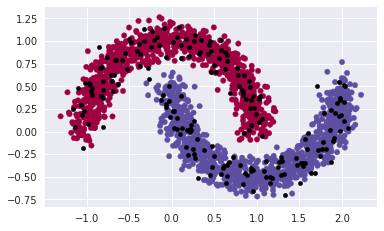

In [4]:
# Using seaborn's style
plt.style.use('seaborn')
width = 430
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
#ax.plot(L)
#ax.set_xlim(0, 2 * np.pi)
#ax.set_xlabel(r'Iterations')
#ax.set_ylabel(r'Training Loss')
# Save and remove excess whitespace
#fig.savefig('training_loss_tinyimg.pdf', format='pdf', bbox_inches='tight')
np.random.seed(0)
#X_orig, y = sklearn.datasets.make_moons(50000, noise=0.3, random_state=0)
X_orig, y = sklearn.datasets.make_moons(2000, noise=0.1, random_state=0)
Xt_orig, yt = sklearn.datasets.make_moons(200, noise=0.1, random_state=0)
ax.scatter(X_orig[:,0], X_orig[:,1], s=30, c=y, cmap=plt.cm.Spectral)
ax.scatter(Xt_orig[:,0], Xt_orig[:,1], s=20, color='black', cmap=plt.cm.Spectral)

fig.savefig('twomoonsdataset.pdf', format='pdf', bbox_inches='tight')

In [5]:
X_orig = torch.from_numpy(X_orig).float()
y = torch.from_numpy(y).float().reshape(-1,1)

Xt_orig = torch.from_numpy(Xt_orig).float()
yt = torch.from_numpy(yt).float().reshape(-1,1)

In [6]:
X_mean, X_std = X_orig.mean(dim=0), X_orig.std(dim=0)

X = (X_orig - X_mean) / X_std
Xt = (Xt_orig - X_mean) / X_std

# Define a basic MLP in full precision

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, act_func='tanh', output_var=False, bias=True, use_bn=False, learn_bn=True, only_last_bn=True):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_var = output_var
        self.use_bn = use_bn
        self.only_last_bn = only_last_bn
        bn_momentum = 0.15
        bn_eps = 1e-4

        if output_size is not None:
            self.output_size = output_size
        else :
            self.output_size = 1

        # Set activation function
        if act_func == 'relu':
            self.act = torch.relu
        elif act_func == 'tanh':
            self.act = torch.tanh
        elif act_func == 'sigmoid':
            self.act = torch.sigmoid

        # Define layers
        if len(hidden_sizes) == 0:
            # Linear model
            self.hidden_layers = []
            self.output_layer = nn.Linear(self.input_size, self.output_size, bias=bias)
            if use_bn:
                self.output_bn = nn.BatchNorm1d(self.output_size, eps=bn_eps, momentum=bn_momentum, affine=learn_bn)
            if output_var:
                self.output_layer_logvar = nn.Linear(self.input_size, self.output_size, bias=bias)
                if use_bn:
                    self.output_logvar_bn = nn.BatchNorm1d(self.output_size, eps=bn_eps, momentum=bn_momentum, affine=learn_bn)
        else:
            # Neural network
            self.hidden_layers = nn.ModuleList([nn.Linear(in_size, out_size, bias=bias) for in_size, out_size in zip([self.input_size] + hidden_sizes[:-1], hidden_sizes)])
            if use_bn and not only_last_bn:
                self.batch_norms = nn.ModuleList([nn.BatchNorm1d(in_size, eps=bn_eps, momentum=bn_momentum, affine=learn_bn) for in_size in hidden_sizes])
            self.output_layer = nn.Linear(hidden_sizes[-1], self.output_size, bias=bias)
            if use_bn:
                self.output_bn = nn.BatchNorm1d(self.output_size, eps=bn_eps, momentum=bn_momentum, affine=learn_bn)
            if output_var:
                self.output_layer_logvar = nn.Linear(hidden_sizes[-1], self.output_size, bias=bias)
                if use_bn:
                    self.output_logvar_bn = nn.BatchNorm1d(self.output_size, eps=bn_eps, momentum=bn_momentum, affine=learn_bn)

    def forward(self, x):
        x = x.view(-1,self.input_size)
        out = x
        for i in range(len(self.hidden_layers)):
            out = self.hidden_layers[i](out)
            out = self.batch_norms[i](out) if self.use_bn and not self.only_last_bn else out
            out = self.act(out)
        z = self.output_layer(out)
        z = self.output_bn(z) if self.use_bn else z
        if self.output_var:
            z_logvar = self.output_layer_logvar(out)
            z_logvar = self.output_logvar_bn(z_logvar) if self.use_bn else z_logvar
            return z, z_logvar
        return z

    def predict(self, x):
        logits = self.forward(x)
        prob = torch.sigmoid(logits)
        return prob.reshape(-1).detach().numpy()

    def predict_multi(self, x):
        logits = self.forward(x)
        prob = torch.softmax(logits, dim=1)
        return prob.detach().numpy()

## Function to train a full precision NN

In [8]:
def real_net(ax, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader):
    model = MLP(2, [3], 1, act_func='relu', output_var=False, bias=False, use_bn=True, learn_bn=False, only_last_bn=False)
    model = model.to(torch.device("cuda:1"))
    #model.fc1.weight.data = 0*model.fc1.weight.data.sign()

    optimizer = optim.SGD(model.parameters(), lr=lr_start)

    L = list()
    list_test_loss = list()
    list_test_accuracy = list()

    for i in range(epochs):
        if i in lr_decay_epochs:
            print('decay!!!')
            for param_group in optimizer.param_groups:
                param_group['lr'] *=  lr_decay

        for j, data in enumerate(train_loader):
            model.train(True)
            inputs, labels = data
            Xbatch, ybatch = inputs.to(torch.device("cuda:1")), labels.to(torch.device("cuda:1"))
            output = model.forward(Xbatch)
            criterion = nn.BCEWithLogitsLoss()
            loss = criterion(output, ybatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            L.append(loss.detach().cpu().numpy())

            
        model.eval()
        test_loss = 0
        total_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(torch.device("cuda:1")), target.to(torch.device("cuda:1"))
                output = model(data)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = (output.sign()+1)/2  # get the index of the max log-probability
                total_correct += pred.eq(target.view_as(pred)).sum().item()
        list_test_loss.append(test_loss/len(test_loader.sampler))
        list_test_accuracy.append(total_correct / len(test_loader.sampler))
        print(test_loss)

    ax.plot(L, color='C3')
    
    #for param in model.parameters():
        #param.data = param.data.sign().detach()
    model.eval()
    final_binary_test_loss = 0
    final_binary_total_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(torch.device("cuda:1")), target.to(torch.device("cuda:1"))
            output = model(data)
            final_binary_test_loss += criterion(output, target).item()  # sum up batch loss
            pred = (output.sign()+1)/2  # get the index of the max log-probability
            final_binary_total_correct += pred.eq(target.view_as(pred)).sum().item()
    
    return model, L, list_test_loss, list_test_accuracy, final_binary_test_loss/len(test_loader.sampler), final_binary_total_correct/ len(test_loader.sampler)

## Classes imported from AdaSTE's 

In [9]:
class FenBPOpt(Optimizer):

    def __init__(self, model, train_set_size, lr=1e-4, betas=0.0, delta=1e-6, eta=0.9999, lamda_init=10, lamda_std=0, reweight=1, use_STE=False, fenbp_alpha = 0.01, fenbp_beta = 0.01):
        if train_set_size < 1:
            raise ValueError("Invalid number of datapoints: {}".format(train_set_size))

        defaults=dict(lr=lr, train_set_size=train_set_size, beta=betas)
        super(FenBPOpt, self).__init__(model.parameters(), defaults)

        self.train_modules = []
        self.set_train_modules(model)

        defaults = self.defaults
        parameters = self.param_groups[0]['params']
        self.param_groups[0]['lr'] = lr

        device = parameters[0].device

        p = parameters_to_vector(self.param_groups[0]['params'])

        mixtures_coeff = torch.randint_like(p,2)
        self.state['lamda'] =  mixtures_coeff * (lamda_init + np.sqrt(lamda_std)* torch.randn_like(p)) + (1-mixtures_coeff) * (-lamda_init + np.sqrt(lamda_std) * torch.randn_like(p))#  torch.log(1+p_value) - torch.log(1-p_value)  #torch.randn_like(p) # 100*torch.randn_like(p) # math.sqrt(train_set_size)*torch.randn_like(p)  #such initialization is empirically good, others are OK of course
        #self.state['lamda'] =  torch.zeros_like(p)
        #self.state['lamda'] = p.detach()
        
        #Momentum term
        self.state['momentum'] = torch.zeros_like(p, device=device) # momentum

        # step initilization
        self.state['step'] = 0
        self.state['reweight'] = reweight
        self.state['delta']=delta
        self.state['eta']=eta
        self.state['use_STE']=use_STE

        self.alpha = fenbp_alpha
        self.beta = fenbp_beta

    def set_train_modules(self, module):
        if len(list(module.children())) == 0:
            if len(list(module.parameters())) != 0:
                self.train_modules.append(module)
        else:
            for child in list(module.children()):
                self.set_train_modules(child)

    def get_grad(self, closure, theta, delta, eta, straight_through=False):
        parameters = self.param_groups[0]['params']

        #Annealing parameter
        beta = self.beta
        alpha = self.alpha

        # y = theta
        
        # Compute w*
        if straight_through:
            w_vector = torch.sign(theta)
        else:
            #print('insidehardtanh=', (theta + beta * (1 + alpha)*theta.sign())/(1 + beta))
            w_vector = F.hardtanh((theta + beta * (1 + alpha)*theta.sign())/(1 + beta), 
                    min_val=-1.0, max_val=1.0)

        # Pass to the model 
        vector_to_parameters(w_vector, parameters)
        
        #print('w_vector', w_vector)
        
        # Get loss and predictions
        loss, preds = closure()

        linear_grad = torch.autograd.grad(loss, parameters)  # compute the gradidents
        grad = parameters_to_vector(linear_grad).detach()
        
        #print('gradbefore', grad)

        # Use sign to evaluate
        vector_to_parameters(torch.sign(theta), parameters)
        loss, preds = closure()

        if straight_through:
            return loss, preds, grad

        # Scale the gradients
        scale = torch.ones_like(theta)

        mask_pos_grad = grad > 1e-3
        mask_neg_grad = grad < -1e-3

        if (beta * alpha < 1):
            scale *= 1/(1 + beta)
            mask_pos_x = theta > max(1e-6, 1 - beta * alpha)
            mask_neg_x = theta < min(-1e-6,-1 + beta * alpha)

            mask_pos_mid_x  = (1e-6 < theta) & (theta < 1 - beta * alpha)
            mask_neg_mid_x = (-1 + beta * alpha < theta ) & ( theta  < -1e-6)

            mask = (mask_pos_x & mask_neg_grad) | (mask_neg_x & mask_pos_grad)
            scale[mask] = 0.0
            
            mask = (mask_neg_grad & mask_neg_x) | (mask_pos_grad & mask_pos_x)
            scale[mask] = torch.clamp( ((1 + 2*beta + beta*alpha)/(1 + beta))* 1./theta[mask].abs(), min=0, max = 0.5 )

            mask = (mask_neg_grad & mask_neg_mid_x) | (mask_pos_grad & mask_pos_mid_x)
            scale[mask] = torch.clamp( ((2*beta*(1+alpha) - theta[mask])/(1 + beta))*1./theta[mask].abs(), min=0, max = 0.5)

        else:
            mask_pos_x = theta > 1e-3
            mask_neg_x = theta < -1e-3

            mask = (mask_pos_x & mask_pos_grad) | (mask_neg_x & mask_neg_grad)
            scale[mask] = torch.clamp(1./theta[mask].abs(), min=0, max = 0.5)

            mask = (mask_pos_x & mask_neg_grad) | (mask_neg_x & mask_pos_grad)
            scale[mask] = 0.0

        grad *= scale
        #print('grad', grad)
        return loss, preds, grad

    def step(self, closure):
        """Performs a single optimization step.
        Arguments:
            closure (callable): A closure that reevaluates the model
                and returns the loss without doing the backward pass
        """
        if closure is None:
            raise RuntimeError(
                'For now, BayesBiNN only supports that the model/loss can be reevaluated inside the step function')

        loss_list = []
        pred_list = []
        self.state['step'] += 1

        defaults = self.defaults
        # We only support a single parameter group.
        parameters = self.param_groups[0]['params']
        lr = self.param_groups[0]['lr']
        momentum_beta = defaults['beta']
        momentum = self.state['momentum']

        # mu = self.state['mu']
        lamda = self.state['lamda']
        reweight = self.state['reweight']

        grad_hat = torch.zeros_like(lamda)

        delta = self.state['delta']
        eta = self.state['eta']
        
        # Obtain gradients
        loss, pred, gr = self.get_grad(closure, lamda, delta=delta, eta = self.state['eta'], straight_through=self.state['use_STE'] )

        loss_list.append(loss)
        pred_list.append(pred)

        #grad_hat = gr
        grad_hat = defaults['train_set_size'] * gr
        #grad_hat = grad_hat.mul(defaults['train_set_size'])

        # Add momentum
        self.state['momentum'] = momentum_beta * self.state['momentum'] + (1-momentum_beta)*(grad_hat + reweight*(self.state['lamda'] ))

        # Get the mean loss over the number of samples
        loss = torch.mean(torch.stack(loss_list))

        # Bias correction of momentum as adam
        bias_correction1 = 1 - momentum_beta ** self.state['step']

        # Update lamda vector
        self.state['lamda'] = self.state['lamda'] - self.param_groups[0]['lr'] * self.state['momentum']/bias_correction1
        #print("self.state['lamda']", self.state['lamda'])

        return loss, pred_list

# Function to train AdaSTE

In [10]:
def adaste(ax, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader):
    model = MLP(2, [3], 1, act_func='relu', output_var=False, bias=False, use_bn=True, learn_bn=False, only_last_bn=False)
    model = model.to(torch.device("cuda:1"))

    effective_trainsize = len(train_loader.sampler)
    optimizer=FenBPOpt(model,train_set_size=effective_trainsize, 
                delta = 1e-6,
                lr = lr_start,
                use_STE = False,
                betas = .9,
                fenbp_alpha = 0.01,
                fenbp_beta = 100.
                )

    L = list()
    list_test_loss = list()
    list_test_accuracy = list()

    for i in range(epochs):

        if i in lr_decay_epochs:
            print('decay!!!')
            for param_group in optimizer.param_groups:
                param_group['lr'] *=  lr_decay

        for j, data in enumerate(train_loader):
            model.train(True)
            inputs, labels = data
            Xbatch, ybatch = inputs.to(torch.device("cuda:1")), labels.to(torch.device("cuda:1"))
            criterion = nn.BCEWithLogitsLoss()

            def closure():
                optimizer.zero_grad()
                output = model.forward(Xbatch)
                loss = criterion(output, ybatch)
                return loss, output

            loss, output = optimizer.step(closure)

            L.append(loss.detach().cpu().numpy())
            
        ax.plot(L, color='C4')
            
        model.eval()
        test_loss = 0
        total_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(torch.device("cuda:1")), target.to(torch.device("cuda:1"))
                output = model(data)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = (output.sign()+1)/2  # get the index of the max log-probability
                total_correct += pred.eq(target.view_as(pred)).sum().item()
        list_test_loss.append(test_loss/len(test_loader.sampler))
        list_test_accuracy.append(total_correct / len(test_loader.sampler))
        print(test_loss)
    
    return model, L, list_test_loss, list_test_accuracy, list_test_loss[-1], list_test_accuracy[-1]


#### Run quick test for AdaSTE and full precision NNs

0.47762396931648254
0.4399665594100952
0.4345207214355469
0.4290675222873688
0.4413570761680603
0.437794029712677
0.4380933940410614
0.4398103356361389
0.4371137022972107
0.4376637935638428
0.43725505471229553
0.4387790560722351
0.4386594593524933
0.4335455298423767
0.44066309928894043
0.43932846188545227
0.43874648213386536
0.43963080644607544
0.4386618733406067
0.44121038913726807
0.43504852056503296
0.43707892298698425
0.43539756536483765
0.4316595792770386
0.4330926835536957
0.431437224149704
0.42832350730895996
0.4285852015018463
0.4254711866378784
0.4252770245075226
decay!!!
0.42131003737449646
0.41997772455215454
0.42218923568725586
0.4172064960002899
0.4194772243499756
0.4193906784057617
0.4159267246723175
0.4169624149799347
0.4153077304363251
0.4160812199115753
0.41592347621917725
0.4122219383716583
0.418297678232193
0.41429781913757324
0.4151461720466614
0.41284963488578796
0.41591307520866394
0.41343969106674194
0.41384604573249817
0.4142396152019501
0.41388434171676636
0.41

0.41162770986557007
0.40781188011169434
0.41144201159477234
0.41073668003082275
decay!!!
0.41005733609199524
0.40895891189575195
0.40916913747787476
0.41425079107284546
0.40945032238960266
0.40777823328971863
0.40758833289146423
0.4096599519252777
0.4076831042766571
0.4091361165046692
0.4072064459323883
0.4098440408706665
0.40754255652427673
0.41153258085250854
0.40848052501678467
0.4084542691707611
0.40889933705329895
0.40869757533073425
0.412448912858963
0.4088875353336334
0.4067271947860718
0.41038116812705994
0.40989553928375244
0.41035911440849304
0.4098968505859375
0.4106106758117676
0.4119952917098999
0.4115845859050751
0.41068434715270996
0.4088725447654724
decay!!!
0.41160890460014343
0.40782293677330017
0.4099873900413513
0.40661105513572693
0.40919816493988037
0.4080537259578705
0.4070886969566345
0.4092712998390198
0.40853145718574524
0.41299787163734436
0.4111555814743042
0.4096323251724243
0.40957963466644287
0.4080113470554352
0.41060537099838257
0.40741854906082153
0.41

0.41221413016319275
0.4121670722961426
0.4125828146934509
0.4130125045776367
0.41267287731170654
0.4109862148761749
0.4103274941444397
0.410409539937973
0.41185855865478516
0.4103693962097168
0.40986618399620056
0.4121863842010498
0.41058310866355896
decay!!!
0.41280150413513184
0.412840336561203
0.40844622254371643
0.4111875891685486
0.4113474488258362
0.41176027059555054
0.4097422957420349
0.41290903091430664
0.4113704562187195
0.41093680262565613
0.4110472798347473
0.41103628277778625
0.4110688269138336
0.41305404901504517
0.41171795129776
0.40876510739326477
0.41045406460762024
0.4135268032550812
0.4122975170612335
0.4099265933036804
0.41222015023231506
0.4098944067955017
0.4078332185745239
0.4089420735836029
0.41162002086639404
0.41265439987182617
0.4104555547237396
0.41029712557792664
0.4103644788265228
0.41184860467910767
0.41248565912246704
0.4122983515262604
0.4128084182739258
0.4118553698062897
0.4131065309047699
0.41086500883102417
0.41205596923828125
0.41130292415618896
0.4

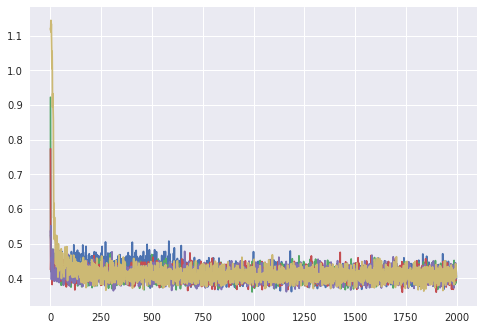

In [37]:
binary_accuracy_real = list()

binary_loss_real = list()
binary_loss_adaste = list()


for rep in range(5):

    lr_start=0.1
    lr_decay_epochs = [30, 60]
    lr_decay=1.
    epochs=100
    bs=100


    train_dataset = BasicDataset(X, y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_dataset = BasicDataset(Xt, yt)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False)



    model_real, train_loss_real, test_loss_real, test_accuracy_real, binloss_real, binacc_real =  real_net(epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
    model_adaste, train_loss_adaste, test_loss_adaste, test_accuracy_adaste, binloss_adaste, binacc_adaste =  adaste(epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)

    binary_accuracy_real.append(binacc_real)    
    binary_loss_real.append(test_loss_real[-1])
    binary_loss_adaste.append(binloss_adaste)
    
print('Accuracy after binarization:')
print(np.mean(binary_accuracy_real))
print(np.std(binary_accuracy_real))
print('Loss real:')
print(np.mean(binary_loss_real))
print(np.std(binary_loss_real))
print('Loss AdaSTE:')
print(np.mean(binary_loss_adaste))
print(np.std(binary_loss_adaste))

In [11]:
import torch.nn as nn
import math

## Classes for BinaryConnect (stochastic version of STE)

In [12]:
from torch.autograd import Function

class BinarizeF2(Function):
    @staticmethod
    def forward(cxt, input):
        sigma = torch.clamp((input+1)/2, 0, 1)
        output = 2 * torch.bernoulli(sigma) - 1
        return output

    @staticmethod
    def backward(cxt, grad_output):
        grad_input = grad_output.clone()
        return grad_input
# aliases
binarize2 = BinarizeF2.apply


class BinaryLinear2(nn.Linear):

    def forward(self, input):
        # binary_weight = binarize(self.weight)
        #if input.size(1) != 784:
        #    input.data = binarize(input.data)
        if not hasattr(self.weight, 'org'):
            self.weight.org = self.weight.data.clone()
        self.weight.data = binarize2(self.weight.org)
        out = nn.functional.linear(input, self.weight)
        if not self.bias is None:
            self.bias.org = self.bias.data.clone()
            out += self.bias.view(1, -1).expand_as(out)

        return out


    def reset_parameters(self):
        # Glorot initialization
        in_features, out_features = self.weight.size()
        stdv = math.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv

#### Define a STE MLP

In [13]:
class MLP_STE_sto(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, act_func='tanh', output_var=False, bias=True, use_bn=False, learn_bn=True, only_last_bn=True):
        super(MLP_STE_sto, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_var = output_var
        self.use_bn = use_bn
        self.only_last_bn = only_last_bn
        bn_momentum = 0.15
        bn_eps = 1e-4

        if output_size is not None:
            self.output_size = output_size
        else :
            self.output_size = 1

        # Set activation function
        if act_func == 'relu':
            self.act = torch.relu
        elif act_func == 'tanh':
            self.act = torch.tanh
        elif act_func == 'sigmoid':
            self.act = torch.sigmoid

        # Define layers
        if len(hidden_sizes) == 0:
            # Linear model
            self.hidden_layers = []
            self.output_layer = BinaryLinear2(self.input_size, self.output_size, bias=bias)
            if use_bn:
                self.output_bn = nn.BatchNorm1d(self.output_size, eps=bn_eps, momentum=bn_momentum, affine=learn_bn)
            if output_var:
                self.output_layer_logvar = BinaryLinear2(self.input_size, self.output_size, bias=bias)
                if use_bn:
                    self.output_logvar_bn = nn.BatchNorm1d(self.output_size, eps=bn_eps, momentum=bn_momentum, affine=learn_bn)
        else:
            # Neural network
            self.hidden_layers = nn.ModuleList([BinaryLinear2(in_size, out_size, bias=bias) for in_size, out_size in zip([self.input_size] + hidden_sizes[:-1], hidden_sizes)])
            if use_bn and not only_last_bn:
                self.batch_norms = nn.ModuleList([nn.BatchNorm1d(in_size, eps=bn_eps, momentum=bn_momentum, affine=learn_bn) for in_size in hidden_sizes])
            self.output_layer = BinaryLinear2(hidden_sizes[-1], self.output_size, bias=bias)
            if use_bn:
                self.output_bn = nn.BatchNorm1d(self.output_size, eps=bn_eps, momentum=bn_momentum, affine=learn_bn)
            if output_var:
                self.output_layer_logvar = BinaryLinear2(hidden_sizes[-1], self.output_size, bias=bias)
                if use_bn:
                    self.output_logvar_bn = nn.BatchNorm1d(self.output_size, eps=bn_eps, momentum=bn_momentum, affine=learn_bn)
    
    def forward(self, x):
        x = x.view(-1,self.input_size)
        out = x
        for i in range(len(self.hidden_layers)):
            out = self.hidden_layers[i](out)
            out = self.batch_norms[i](out) if self.use_bn and not self.only_last_bn else out
            out = self.act(out)
        z = self.output_layer(out)
        z = self.output_bn(z) if self.use_bn else z
        if self.output_var:
            z_logvar = self.output_layer_logvar(out)
            z_logvar = self.output_logvar_bn(z_logvar) if self.use_bn else z_logvar
            return z, z_logvar
        return z

    def predict(self, x):
        logits = self.forward(x)
        prob = torch.sigmoid(logits)
        return prob.reshape(-1).detach().numpy()

    def predict_multi(self, x):
        logits = self.forward(x)
        prob = torch.softmax(logits, dim=1)
        return prob.detach().numpy()

# Function to train BinaryConnect

In [14]:
def sto_binaryconnect_net(ax, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader):
    model = MLP_STE_sto(2, [3], 1, act_func='relu', output_var=False, bias=False, use_bn=True, learn_bn=False, only_last_bn=False)
    model = model.to(torch.device("cuda:1"))
    #model.fc1.weight.data = 0*model.fc1.weight.data.sign()

    optimizer = optim.SGD(model.parameters(), lr=lr_start)

    L = list()
    list_test_loss = list()
    list_test_accuracy = list()

    for i in range(epochs):
        if i in lr_decay_epochs:
            print('decay!!!')
            for param_group in optimizer.param_groups:
                param_group['lr'] *=  lr_decay

        for j, data in enumerate(train_loader):
            model.train(True)
            inputs, labels = data
            Xbatch, ybatch = inputs.to(torch.device("cuda:1")), labels.to(torch.device("cuda:1"))
            output = model.forward(Xbatch)
            criterion = nn.BCEWithLogitsLoss()
            loss = criterion(output, ybatch)
            optimizer.zero_grad()
            loss.backward()
            for p in list(model.parameters()):
                if hasattr(p, 'org'):
                    p.data.copy_(p.org)
            optimizer.step()
            for p in list(model.parameters()):
                if hasattr(p, 'org'):
                    p.org.copy_(p.data.clamp_(-1, 1))
            L.append(loss.detach().cpu().numpy())

            
        model.eval()
        test_loss = 0
        total_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(torch.device("cuda:1")), target.to(torch.device("cuda:1"))
                output = model(data)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = (output.sign()+1)/2  # get the index of the max log-probability
                total_correct += pred.eq(target.view_as(pred)).sum().item()
        list_test_loss.append(test_loss/len(test_loader.sampler))
        list_test_accuracy.append(total_correct / len(test_loader.sampler))
        print(test_loss)

    ax.plot(L, color='C2')

    return model, L, list_test_loss, list_test_accuracy, list_test_loss[-1], list_test_accuracy[-1]

# Function to train AskewSGD

In [15]:
def ours_net(ax, epsilon, alpha, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader):
    model = MLP(2, [3], 1, act_func='relu', output_var=False, bias=False, use_bn=True, learn_bn=False, only_last_bn=False)
    model = model.to(torch.device("cuda:1"))
    #model.fc1.weight.data = 0*model.fc1.weight.data.sign()

    #optimizer = optim.SGD(model.parameters(), lr=lr_start)
    optimizer = optim.Adam(model.parameters(), lr=lr_start)

    L = list()
    list_test_loss = list()
    list_test_accuracy = list()
    #norm_list = list()

    for i in range(epochs):
        #norm_list.append(torch.norm(parameters_to_vector(model.parameters())**2-1).cpu().detach().numpy())
        #plt.hist(parameters_to_vector(model.hidden_layers[0].weight).cpu().detach().numpy())
        #plt.show()
        #plt.hist(parameters_to_vector(model.output_layer.weight).cpu().detach().numpy())
        #plt.show()
        
        if i < 20:
            epsilon =1.
        else:
            epsilon=.99**(i-20)
            #print(epsilon)
        #epsilon = .96**i
        if i in lr_decay_epochs:
            print('decay!!!')
            for param_group in optimizer.param_groups:
                param_group['lr'] *=  lr_decay

        for j, data in enumerate(train_loader):
            model.train(True)
            inputs, labels = data
            Xbatch, ybatch = inputs.to(torch.device("cuda:1")), labels.to(torch.device("cuda:1"))
            output = model.forward(Xbatch)
            criterion = nn.BCEWithLogitsLoss()
            loss = criterion(output, ybatch)
            optimizer.zero_grad()
            loss.backward()
            for param_group in optimizer.param_groups:
                for idx, p in enumerate(param_group['params']):
                    constr = epsilon-(p.data**2-1)**2
                    Kx = alpha * (epsilon-(p.data**2-1)**2) / (4 * p.data * (p.data**2-1))
                    direct_grad = torch.logical_or(torch.logical_or(p.data==0, constr >= 0), (-p.grad.data)*Kx > Kx**2)
                    p.grad.data[direct_grad] = p.grad.data[direct_grad]
                    p.grad.data[~direct_grad] = -Kx[~direct_grad]
            optimizer.step()
            for p in list(model.parameters()):
                p.data.clamp_(-1, 1)
            L.append(loss.detach().cpu().numpy())

            
        model.eval()
        test_loss = 0
        total_correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(torch.device("cuda:1")), target.to(torch.device("cuda:1"))
                output = model(data)
                test_loss += criterion(output, target).item()  # sum up batch loss
                pred = (output.sign()+1)/2  # get the index of the max log-probability
                total_correct += pred.eq(target.view_as(pred)).sum().item()
        list_test_loss.append(test_loss/len(test_loader.sampler))
        list_test_accuracy.append(total_correct / len(test_loader.sampler))
        #print(test_loss)

    ax.plot(L, color='C0')
    
    for param in model.parameters():
        param.data = param.data.sign().detach()
    model.eval()
    final_binary_test_loss = 0
    final_binary_total_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(torch.device("cuda:1")), target.to(torch.device("cuda:1"))
            output = model(data)
            final_binary_test_loss += criterion(output, target).item()  # sum up batch loss
            pred = (output.sign()+1)/2  # get the index of the max log-probability
            final_binary_total_correct += pred.eq(target.view_as(pred)).sum().item()
    
    return model, L, list_test_loss, list_test_accuracy, final_binary_test_loss/len(test_loader.sampler), final_binary_total_correct/ len(test_loader.sampler)    
    #return final_binary_total_correct/ len(test_loader.sampler), norm_list

# Single training of several methods

0.4369357228279114
0.4134374260902405
0.41330137848854065
0.4126100540161133
0.4139977693557739
0.41138947010040283
0.41348445415496826
0.4113313853740692
0.4117467403411865
0.4100290536880493
0.4109131395816803
0.4116462171077728
0.41106680035591125
0.4125898778438568
0.410537987947464
0.41003039479255676
0.41260063648223877
0.4121185541152954
0.4116102457046509
0.41070324182510376
0.4106541872024536
0.4101808965206146
0.40982192754745483
0.41002926230430603
0.40858709812164307
0.4110873341560364
0.4105773866176605
0.41088974475860596
0.4109917879104614
0.41211578249931335
decay!!!
0.41263338923454285
0.40873363614082336
0.40990346670150757
0.4123222231864929
0.41330206394195557
0.41114556789398193
0.40821605920791626
0.41005122661590576
0.41200950741767883
0.41303449869155884
0.4098714292049408
0.4110378921031952
0.4117366075515747
0.40995341539382935
0.4115257263183594
0.4123471677303314
0.41236433386802673
0.41012462973594666
0.4111080467700958
0.4135834276676178
0.6549538969993591

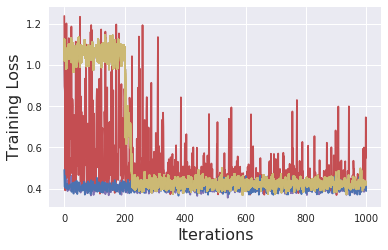

In [16]:
# Using seaborn's style
plt.style.use('seaborn')
width = 430
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
#ax.plot(L)
ax.set_xlabel(r'Iterations', fontsize=16)
ax.set_ylabel(r'Training Loss', fontsize=16)

lr_start=0.1
lr_decay_epochs = [30, 60]
lr_decay=1.
epochs=50
bs=100


train_dataset = BasicDataset(X, y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataset = BasicDataset(Xt, yt)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False)



model_real, train_loss_real, test_loss_real, test_accuracy_real, binloss_real, binacc_real =  real_net(ax, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
model_ste, train_loss_ste, test_loss_ste, test_accuracy_ste, binloss_ste, binacc_ste =  sto_binaryconnect_net(ax, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
model_o, train_loss_o, test_loss_o, test_accuracy_o, binloss_o, binacc_o =  ours_net(ax, 1, 1, epochs, lr_start, lr_decay_epochs, lr_decay, train_loader, test_loader)
model_adaste, train_loss_adaste, test_loss_adaste, test_accuracy_adaste, binloss_adaste, binacc_adaste =  adaste(ax, epochs, lr_start/100, lr_decay_epochs, lr_decay, train_loader, test_loader)

# Save and remove excess whitespace
fig.savefig('training_loss_2moons.pdf', format='pdf', bbox_inches='tight')

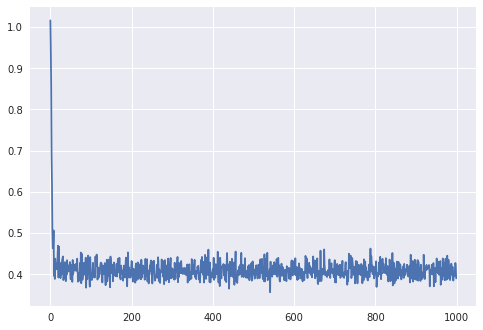

In [17]:
plt.plot(train_loss_real)

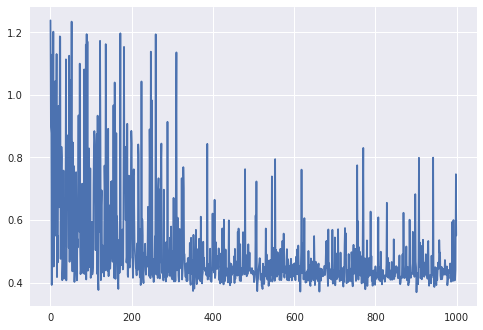

In [18]:
plt.plot(train_loss_ste)

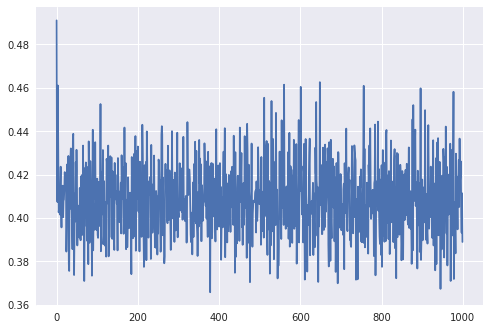

In [19]:
plt.plot(train_loss_o)

In [28]:
model_adaste, train_loss_adaste, test_loss_adaste, test_accuracy_adaste, binloss_adaste, binacc_adaste =  adaste(ax, epochs, lr_start/100, lr_decay_epochs, lr_decay, train_loader, test_loader)

1.1628609895706177
1.169179916381836
1.1572480201721191
1.1664122343063354
1.1608911752700806
1.1486717462539673
1.1668310165405273
1.1707342863082886
1.1530104875564575
1.1857355833053589
1.1760222911834717
0.8930020928382874
0.8768441677093506
0.8897959589958191
0.8750419616699219
0.8928228616714478
0.7235390543937683
0.4591723382472992
0.524563729763031
0.4529759883880615
0.4800826609134674
0.4696964621543884
0.4500168561935425
0.43446287512779236
0.4526573419570923
0.44872862100601196
0.43024975061416626
0.43667060136795044
0.4414946734905243
0.45509442687034607
decay!!!
0.4486944079399109
0.5358734130859375
0.45405569672584534
0.46897879242897034
0.4543472230434418
0.7051413059234619
0.4510211944580078
0.47924140095710754
0.44690757989883423
0.45465749502182007
0.45225369930267334
0.4307002127170563
0.697740912437439
0.44149166345596313
0.4445197284221649
0.4369103014469147
0.47954291105270386
0.4412987530231476
0.42660024762153625
0.4473286271095276


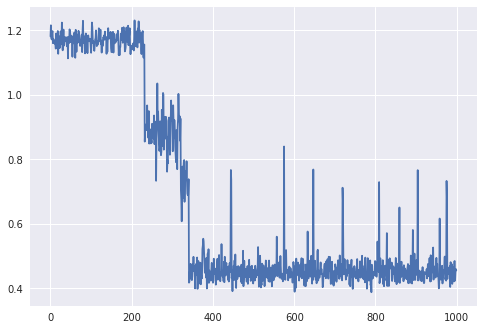

In [29]:
plt.plot(train_loss_adaste)

# Reorder colors and save figure

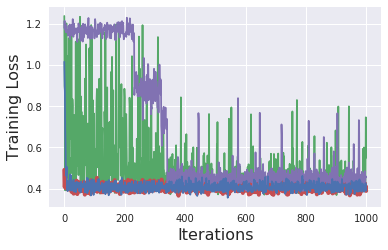

In [32]:
# Using seaborn's style
plt.style.use('seaborn')
width = 430
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
#ax.plot(L)
ax.set_xlabel(r'Iterations', fontsize=16)
ax.set_ylabel(r'Training Loss', fontsize=16)


ax.plot(train_loss_real, zorder=3)
ax.plot(train_loss_ste)
ax.plot(train_loss_o, linewidth=4.)
ax.plot(train_loss_adaste)
# Save and remove excess whitespace
fig.savefig('training_loss_2moons_v2.pdf', format='pdf', bbox_inches='tight')